In [1]:
from songs import *

# НЕЙРОНКИ

In [2]:
import numpy as np
from numpy import random
import queue
import sys
from graphviz import Digraph

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MEMORY_TIMES = 64  # сколько предыдущих моментов времени подаётся на вход
STARTER = 8        # сколько первых моментов времени берём для старта импровизации

ADDITIONAL_MEMORY = 8  # размер дополнительной памяти (в тек. версии - отметки о началах такта)

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY  # суммарный объём памяти

In [4]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]

NAMES = []  # названия входов
for i in range(8):  # отметки о долях идут первыми
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [5]:
class Edge:  # класс связи между нейронами
    def __init__(self, inp, outp, w, was_right=[1, 1], precedents=[1, 1]):
        self.input = inp
        self.output = outp
        self.weight = w
        
        # важные статистики: количество верных ответов вида -1 и 1, и число прецендентов.
        self.was_right = was_right[:]
        self.precedents = precedents[:]
        
    def quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right[self.input.emitted() == 1] / self.precedents[self.input.emitted() == 1]
    
    def op_quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right[self.input.emitted() != 1] / self.precedents[self.input.emitted() != 1]

class Neuron:
    def __init__(self, index, name="", was_one=1, used=2, is_base=False):
        self.name = name        # название для отображения в графе
        
        self.index = index      # номер соответствует индексу в массиве нейронов сети. Это защита от циклов.
        self.is_base = is_base  # пометка, что это вход или выход, и трогать его нельзя
        
        self.inputs = []        # список входов
        self.outputs = []       # список выходов
        self.signal = 0         # сумма текущих входов
        
        # важная статистика: как часто нейрон выдаёт 1
        self.was_one = was_one   # сколько раз сигнал равнялся 1
        self.used = used        # сколько раз вообще проводился запуск
        
        # переменная для хранения качества сигнала
        self.signal_quality = 1
        
        # равно true, если этот нейрон внёс вклад в правильный ответ на каком-то выходе в текущем запуске
        self.success = False       
        
    def initialize(self):
        # инициализация перед запуском
        self.signal = 0
        self.signal_quality = []
        self.success = False
        
    def emitted(self):
        # значение выхода по сумме входов - пороговая функция по нулю
        if self.signal > 0:
            return 1
        return -1
    
    def getSureness(self):
        # сколько входов нужно инвертировать, чтобы получить другой ответ
        if self.signal > 0:
            return (self.signal + 1) // 2
        else:
            return 1 + (-self.signal) // 2
        
    def emit(self, neurons):
        # функция "срабатывание" нейрона
        
        self.used += 1  # подсчёт статистик
        if self.signal > 0:
            self.was_one += 1
        
        sureness = self.getSureness()
            
        if len(self.signal_quality) == 0:
            self.signal_quality = 1
        else:
            self.signal_quality = sorted(self.signal_quality)[sureness - 1]
        
        for edge in self.outputs:  # перебор выходов
            edge.output.signal += edge.weight * self.emitted()  # добавление в сумму своего вклада
            
            # обновляем качество сигнала: оно равняется минимальному качеству входа, 
            # где качество входа - качество сигнала на входе * качество связи
            edge.output.signal_quality.append(edge.quality() * self.signal_quality)   
                
    def reward(self, true_val, error_proba=1):
        # оценивание связи по известному правильному ответу
        
        if self.emitted() == true_val:  # если выдал нужный сигнал, помечаем нейрон как "не трожь!"
            self.success = True
            
        sureness = self.getSureness()
                   
        for edge in self.inputs:
            input_val = edge.input.emitted()  # входной сигнал
            
            edge.precedents[input_val == 1] += 1 * error_proba
            if input_val * edge.weight == true_val:
                edge.was_right[input_val == 1] += 1 * error_proba

            edge.input.reward(true_val * edge.weight, error_proba / sureness)  # переходим во вход рекурсивно

In [267]:
class Func:
    def __init__(self):
        # нейроны-входы
        self.neurons = [Neuron(i, name=NAMES[i], was_one=0, used=1, is_base=True) for i in range(MEMORY_SIZE)]
        # нейроны-выходы
        for i in range(13):                                                                  
            self.neurons.append(Neuron(MEMORY_SIZE + i, name=NOTE_NAMES[i] + "outp", was_one=0, used=1, is_base=True)) 
        
        self.IDS = 0  # id нужны, чтобы различать нейроны, и давать имена скрытым нейронам.
        self.Random = np.random.RandomState(seed=179)  # рандом       
        self.verbose = False  # отладка
        self.depth = ""       # для отладочного вывода
        
    def apply(self, x):  # проход по нейросети
        for neuron in self.neurons:
            neuron.initialize()
        
        # посылаем сигналы на нужные входы
        for i, val in enumerate(x):  
            if val == 1:
                self.neurons[i].signal += 1
        
        # запускаем нейроны
        for N in self.neurons:
            N.emit(self.neurons)
        
        # собираем включившиеся выходы
        return np.array([self.neurons[-13+i].emitted() == 1 for i in range(13)])
    
    def reward(self, true_vals):  # награждаем связи
        for i, val in enumerate(true_vals):
            if val == 1:
                self.neurons[-13+i].reward(1)
            else:
                self.neurons[-13+i].reward(-1)
            
    def forget_info(self):  # сбрасывание всех статистик - опциональная возможность. "Выучил выборку - пересчитай статистики".
        for N in self.neurons:
            for edge in N.inputs:
                edge.was_right = [1, 1]
                edge.precedents = [1, 1]
            
            if N.is_base:
                N.was_one = 0
                N.used = 1
            else:
                N.was_one = 1
                N.used = 2
    
    def randomOne(self, conseq):   # выбор случайного нейрона для создания гипотезы
        # гипотеза в данном контексте - это новая связь
        # гипотеза тем акутальнее, чем более специфично выбранное событие для текущей ситуации
        # то есть хочется выбрать гипотезу, которая срабатывает именно в этом запуске
        # для этого хочется взять событие, которое случилось в данном запуске, но его априорная вероятность очень мала
        # то есть выудить из текущего события какую-нибудь ценную информацию
        # поэтому вероятность выбора гипотезы пропорциональна 1 - P(события)
        
        candidates = []  # список нейронов-кандидатов
        proba = []       # список вероятностей, с котороыми мы их выберем
        
        # перебираем нейроны, стоящие в массиве до следствия, чтобы избежать циклов
        # также мы не берём выходы всей сети (последние 13 нейронов)
        for N in self.neurons[:min(len(self.neurons) - 13, conseq.index)]:
            # ВАЖНО! тут по идеи должна стоять защита от случая, 
            # что этот нейрон уже используется как вход для conseq. Однако...
            candidates.append(N) 
            
            # считаем вероятность
            if N.emitted() == 1:  
                proba.append(1 - N.was_one / N.used)
            else:
                proba.append(N.was_one / N.used)
        
        # делаем случайный выбор
        proba = np.array(proba)
        proba /= proba.sum()
        return self.Random.choice(candidates, p=proba)
    
    def connect(self, N1, N2, w, was_right=[1, 2], precedents=[2, 3]):
        # соединяем два нейрона новой связью; rewards-precedents это её исходная оценка
        if self.verbose:
            print(self.depth, "new edge (w=" + str(w) + ") between layers: ", N1.name, "(", N1.index, ")", " / ", N2.name, "(", N2.index, ")")
        NewEdge = Edge(N1, N2, w, was_right, precedents)
        N1.outputs.append(NewEdge)
        N2.inputs.append(NewEdge)
        return True
    
    def check_for_blow(self, neurons_queue):
        # нейрон отваливается, если у него нет входов или выходов
        # эта функция делает проверку очереди neurons_queue на такие нейроны
        # и уничтожает отвалившиеся
        
        while not neurons_queue.empty():
            N = neurons_queue.get()
            
            # проверяем нейрон; если у него нет входов или выходов, взрываем
            if N in self.neurons and not N.is_base: #возможно, он уже взорван
                if len(N.outputs) == 0:
                    if self.verbose:
                        print(self.depth, "neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.inputs[:]:
                        self.disconnect(edge, neurons_queue)
                elif len(N.inputs) == 0:
                    if self.verbose:
                        print(self.depth, "neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.outputs[:]:
                        self.disconnect(edge, neurons_queue)
                else:
                    continue
                
                # окончательное удаление из списка
                for neuron in self.neurons[N.index:]:
                    neuron.index -= 1
                self.neurons.remove(N)
                
    def disconnect(self, edge, neurons_queue=None):
        # разъединяем связь
        if self.verbose:
            print(self.depth, "remove edge between layers: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        edge.output.inputs.remove(edge)
        edge.input.outputs.remove(edge)
        
        # какие-то нейроны могли остаться без входов или выходов и их нужно взорвать: возвращаем очередь для проверки
        if neurons_queue is None:
            neurons_queue = queue.Queue()
        neurons_queue.put(edge.input)
        neurons_queue.put(edge.output)
        return neurons_queue
        
    def add_stub(self, edge):
        # добавление заглушки, т.е. нового нейрона в сеть
        # выбирается связь, по которой прошёл неверный сигнал, и разрывается нейроном
        # веса для двух новых связей выбираются так, чтобы произведение равнялось весу исходной связи
        # При этом варианта в любом случае два. Заведомо известно, что в стабе будет ошибка, 
        # а количество голосов будет -1 или 1 в зависимости от сигнала с единственного входа
        # Поскольку при 0 нейрон выдаёт -1, то проще 1 исправить в 0, чем -1 в 1
        # => выбираем тот вариант, при котором в стаб придёт сигнал 1
        
        # вычисление положения нейрона в сети. Он должен быть между входом и выходом разрываемой связи
        # и не задеть входной и выходной слой!
        stub_index = 1 + self.Random.randint(max(edge.input.index, MEMORY_SIZE - 1), min(len(self.neurons) - 13, edge.output.index))
        
        # Вообще-то, тут можно ещё вычислить априорную вероятность 1 для нового нейрона (соотв. вероятности единственного входа)
        # ну пока этого нет
        
        # добавление нейрона
        stub = Neuron(stub_index, name=str(self.IDS))
        self.IDS += 1
        
        for neuron in self.neurons[stub_index:]:  # индекс последующих нейронов смещается на единицу
            neuron.index += 1
        self.neurons.insert(stub_index, stub)
        
        stub.signal = 1  # заполняем параметры текущего запуска для корректной работы
        stub.signal_quality = edge.input.signal_quality * edge.quality()
        
        if self.verbose:
            print(self.depth, "created stub (", stub_index, ") between: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        
        # решение уравнения на новые два веса: сигнал со входа; сигнал со входа на исходный вес.
        # при перемножении дадут исходный вес; в стаб придёт 1
        
        # изначальные оценки связей берём из разорванной связи?
        inp_signal = edge.input.emitted()
        self.connect(edge.input, stub, inp_signal)#, edge.was_right, edge.precedents)
        self.connect(stub, edge.output, inp_signal * edge.weight)#, edge.was_right, edge.precedents)
        self.disconnect(edge)
        
        return stub
        
    def turn(self, N, wish, no_recursion=False, error_proba=1):
        # АЛГОРИТМ ПОПРАВКИ!
        self.depth += "    "
        outside_error_proba = 1
        
        if N.emitted() == wish:
            print("ERROR! wish and signal are EQUAL!") 
        
        # Если мы оказались на входе, то сразу говорим, что ничего не вышло
        if N.index < MEMORY_SIZE:
            if self.verbose:
                print(self.depth, N.name, " is input neuron, procedure failed")
            self.depth = self.depth[:-4]
            return False, outside_error_proba
        
        # если этот нейрон выдал правильный сигнал хоть для какого-то выхода, его не трогаем
        if N.success:
            if self.verbose:
                print(self.depth, N.name, " is success neuron, procedure failed")
            self.depth = self.depth[:-4]
            return False, outside_error_proba            
        
        # количество голосов
        votes = N.signal        
        if self.verbose:
            print(self.depth, "turning ", wish, ": ", N.name, " votes = ", votes, ", q = ", N.signal_quality)
                   
        if not no_recursion and len(N.inputs) > 0:  # запрет на рекурсию выставляется в том случае, если мы правим новую заглушку
            edges = N.inputs[:]
            self.Random.shuffle(edges)
            #proba = np.array([edge.quality() * edge.input.signal_quality for edge in edges])
            #edges = self.Random.choice(edges, len(edges), replace=False, p=proba)
            #edges = np.array(edges)[np.argsort(proba)]
            # перебираем входы с неверным пришедшим сигналом
            for edge in edges:
                if edge in N.inputs and edge.input.emitted() * edge.weight != wish:
                    if edge.input.index >= N.index:
                        print("ERROR FATAL CYCLE!")
                    
                    result = False
                    oep = 1
                    if self.Random.uniform(0, 1) < 1 - edge.input.signal_quality:
                        # Ошибка на входе. Делаем рекурсивный переход
                        result, oep = self.turn(edge.input, edge.weight * wish, error_proba / N.getSureness())
                        
                        # если исправить вход не получилось, да ну его нафиг                        
                        if result > 0:
                            # аккуратно считаем, сколько теперь голосов
                            votes += (1 + (edge in N.inputs)) * wish
                        else:
                            outside_error_proba = min(outside_error_proba, oep * edge.quality())
            
                    if not result:
                        if self.Random.uniform(0, 1) < (1 - edge.quality()):# * error_proba:
                            if self.Random.uniform(0, 1) < edge.op_quality() * oep:
                                # Ошибка со связью. Строим стаб.
                                stub = self.add_stub(edge)

                                # В принципе, можно и без рекурсии добавить туда один голос...
                                result, oep = self.turn(stub, -1, no_recursion=True)
                                if result:
                                    votes += 2*wish  # получили два голоса!
                                else:
                                    print("WTF")
                            else:
                                self.check_for_blow(self.disconnect(edge))
                                votes += wish  # получили голос в нужную сторону
                                result = True, outside_error_proba

                    # нейрон, в котором мы сейчас сидим, может взорваться по цепочке;
                    # в таком случае, алгоритм типауспешно заканчивается
                    if not N in self.neurons:
                        if self.verbose:
                            print(self.depth, "we blowed up!")
                        self.depth = self.depth[:-4]
                        return True, max_depth                                           

                    # если голосов хватает, заканчиваем
                    new_pos = -1
                    if votes > 0:
                        new_pos = 1
                    if new_pos == wish:
                        if self.verbose:
                            print(self.depth, "all good, finishing")
                        break
        
        # результат процедуры           
        error = votes
        if wish == 1:
            error = 1 - votes
        
        # если проход по связям не удался, надо добавлять новую связь
        if error == 1:
            if self.verbose:
                print(self.depth, "didn't fix voting situation... (" + str(votes) + ")")
            
            one = self.randomOne(N)
            self.connect(one, N, wish * one.emitted())
            votes += wish
             
        # итоговый результат
        new_pos = -1
        if votes > 0:
            new_pos = 1          
        
        # исправленный нейрон помечаем как хороший в этом запуске
        if new_pos == wish:
            N.success = True
        elif self.verbose:
            print(self.depth, "procedure failed")
        self.depth = self.depth[:-4]
        return new_pos == wish, outside_error_proba
    
    def draw(self):
        # рисуем нейросеть
        dot = Digraph(format='png')
        for N in self.neurons:
            if N.index < MEMORY_SIZE:
                dot.attr('node', shape='doublecircle')
            elif N.is_base:
                dot.attr('node', shape='circle', color='green')
            else:
                dot.attr('node', style='filled', color='lightblue')
                
            if len(N.outputs) > 0 or len(N.inputs) > 0:
                dot.node(label = N.name + "\nq={0:.2f},".format(N.signal_quality) + "\ne={0:.3f}".format(N.was_one / N.used), 
                         name = N.name, size='2')
        
        for N in self.neurons:
            for edge in N.inputs:
                c = "blue"
                if edge.weight == -1:
                    c = "red"
                dot.edge(edge.input.name, edge.output.name, color = c, 
                         label = "{0:.2f}".format(edge.was_right[0] / edge.precedents[0]) + 
                           "/" + "{0:.2f}".format(edge.was_right[1] / edge.precedents[1]))
        #dot.render(view=True)
        return dot

In [268]:
class Player:
    def __init__(self):
        self.play_note = Func()
           
    def learn_to_play(self, song_to_learn, verbose=False, learn=True, limit = -1):
        if limit == -1:
            limit = len(song_to_learn.notes)
        self.play_note.verbose = verbose
        
        # исходная память
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        
        # считаем ошибки
        errors = 0
        
        while t < limit:    
            # играем
            output = self.play_note.apply(memory)
            # награждаем связи
            self.play_note.reward(song_to_learn.notes[t])
            
            if verbose:
                print(output.astype(int))
            
            # ищем ошибки
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    if learn:  # дообучаемся: говорим исправиться на этом входе
                        if output[note] == 0:
                            self.play_note.turn(self.play_note.neurons[-13 + note], 1)
                        else:
                            self.play_note.turn(self.play_note.neurons[-13 + note], -1)
                    #return t
            
            # переходим к следующей итерации
            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
            
        return errors
    
    def improvise(self, starter, length=128):  # играет чё хочет
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = self.play_note.apply(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [269]:
player = Player()

In [270]:
kuznechik = Song('../basic midi/track (1).mid')

In [271]:
player.learn_to_play(kuznechik, verbose=True, limit=128)

[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  Aoutp  votes =  0 , q =  1
     didn't fix voting situation... (0)
     new edge (w=1) between layers:  E-2 ( 818 )  /  Aoutp ( 849 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  G#outp  votes =  0 , q =  1
     didn't fix voting situation... (0)
     new edge (w=-1) between layers:  A-9 ( 732 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 1 0 0 0 0]
     turning  -1 :  G#outp  votes =  1 , q =  0.5
     didn't fix voting situation... (1)
     new edge (w=1) between layers:  A-9 ( 732 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  G#outp  votes =  0 , q =  0.3333333333333333
     didn't fix voting situation... (0)
     new edge (w=1) between layers:  E-6 ( 766 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
     turning  1 :  G#outp  votes =  -1 , q =  0.3333333333333333
     created stub ( 840 ) between:  A-9 ( 73

     turning  -1 :  C^outp  votes =  2 , q =  0.13333333333333333
         turning  -1 :  10  votes =  2 , q =  0.2
         procedure failed
     procedure failed
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0]
     turning  -1 :  G#outp  votes =  1 , q =  0.0076824583866837385
         turning  -1 :  7  votes =  1 , q =  0.2
         didn't fix voting situation... (1)
         new edge (w=-1) between layers:  A-64 ( 17 )  /  7 ( 842 )
     all good, finishing
     turning  1 :  Aoutp  votes =  -3 , q =  0.9032258064516129
     created stub ( 840 ) between:  E-30 ( 454 )  /  Aoutp ( 857 )
     new edge (w=-1) between layers:  E-30 ( 454 )  /  11 ( 840 )
     new edge (w=-1) between layers:  11 ( 840 )  /  Aoutp ( 857 )
     remove edge between layers:  E-30 ( 454 )  /  Aoutp ( 857 )
         turning  -1 :  11  votes =  1 , q =  0.8909090909090909
         didn't fix voting situation... (1)
         new edge (w=1) between layers:  E-20 ( 584 )  /  11 ( 840 )
     remove edge be

75

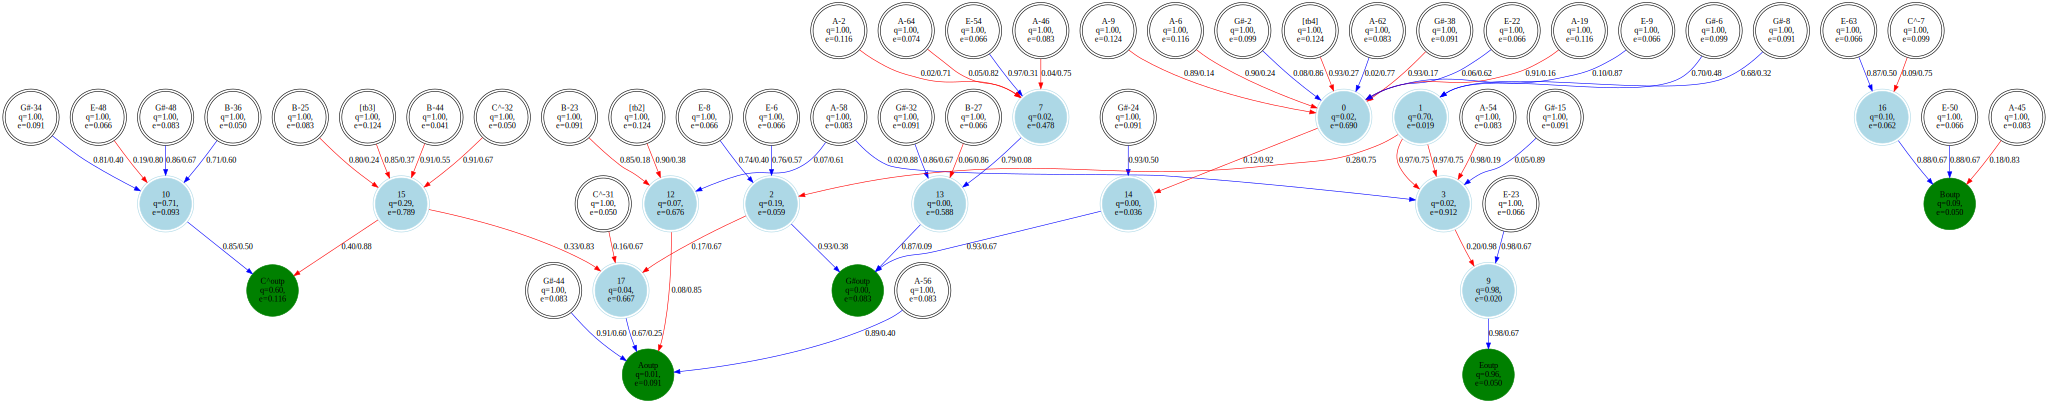

In [272]:
player.play_note.draw()

In [273]:
#player.play_note.draw().render("Бинарный слон запомнил (с FI) кузнечика (54 скрытых нейрона)")

In [274]:
len(player.play_note.neurons[-5].inputs)

3

## БИНАРНЫЙ СЛОН
"Логичная" версия. Вводим статистики:
edge_quality - для связи считаем точность отдельно для выдачи 1 и для выдачи -1. Изначальная оценка - 1/1, 1/1
signal_quality - для нейрона min(edge_quality * edge.input.signal_quality). Для инпутов всегда 1

Корректировка значения в нейроне:
Перебираем входы с неверным сигналом, отсортированные по signal_quality * edge_quality.

Возможны четыре случая: сигнал верен или неверен, связь верна или неверна. Вероятности четырёх случаев известны по edge_quality и signal_quality. Засэмплируем её реализацию случайно.
- сигнал неверен, связь верна: рекурсивный переход.
- связь неверна, сигнал верен: стаб
- неверно и то, и то: перебор связей завершается.
- оба верно: перебор связей завершается

Если после очередного шага получили нужное количество голосов, перебор заканчиваем.

Если не хватает 1 голоса, добавляем связь.

### Результаты:
В итоге стандартной процедуры получается 947 нейронов.

При пообъектном обучении с FI застрявает на единицах. Огромное число связей зависает на выходах. Практически не выходит вглубь из-за "хороших статистик"...

### Модификации:
- ok - ничего, оба неверно - удаление ребра. до 102 с 907 нейронами без FI, застрявает ещё чуть на 85

- статисткиа считается для всех связей, неважно принимали ли они решение, ok - ничего, оба неверно - прерываемся. Сидит на единицах, с хорошим числом нейронов пыхтит до 97; включение FI не решает

- статистика считается с учётом error_proba. Обучение: полное. 956 нейронов, проблемы те же

- SQ теперь не минимум, а с учётом количества голосов. Если -2 голоса, то второй минимум, например. Застрявает на 87, нейронов немало, но схлопывается иногда чуть-чуть, на 102 на единицах стопорится.

- ничего не делать при both wrong. Избыток нейронов. Умирает на 81

- удалять связь при both_wrong с вероятностью error_proba, которая считается как произведение eq с конца. Избыток нейронов.

- При both_wrong ничего не делать, но с вероятностью error_proba менять на wrong_edge или wrong_input. Застрявает из-за схлопывания на 69. Долго сидит на 1 на 83. Застрявает на 85.

- Строить новую связь, если ещё есть ошибки в принципе, с вероятностью error_proba. Долетает до 69, проходит с большим трудом и застрявает на 81. С FI идёт медленнее, но постабильнее, до 87...

- Строить новую связь, если ещё есть ошибки в принципе. Доходит до 89, где умирает от числа нейронов. Без FI - до 91.

- Строим новую связь только при 1 ошибке. При both wrong смотрим на op_decision, берём wrong edge или wrong input если попадается. Застрявает на 85

- При op both wrong хотели бы удалить связь, но делаем это с вероятностью error_proba. Иначе прерываемся. Стоим на 69.

- Не прерываемся... На 67 взрыв количества нейронов и смерть.

- При both wrong удаляем, при wrong input при неудаче не удаляем... На 37 смерть

- both wrong - ничего не делаем, строим новую связь только при 1 ошибке... Но учитывать op_eq при четырёх выероятностях. Резкий взрыв числа нейронов, где-то бага?

# ИНДИВИДУАЛЬНОЕ СЭМПЛИРОВАНИЕ

Перебираем входы в случайном порядке
Сэмплируем успех во входе. Если неуспех, рекурсивно переходим. Если переход был успешен, переходим к следующей связи.

С вероятностью signal_quality в текущем нейроне сэмплируем успех в связи. Если неудача, сэмплируем opEQ. Если opEQ, значит надо делать стаб. Иначе связь разрывается.

Интерпретация: заходим вглубь сети, затем возвращаемся в поисках места ошибки.

### Результаты:
Проблема избытка нейронов решилась, однако действия сеть теперь совершает очень нерешительно. В результате сидит на 1-2 на 69. А вот при стандартной процедура наблюдается резкий неприличный рост нейронов.

# ВОЗВРАТНЫЙ АЛГОРИТМ
(текущая реализация)

Перебираем входы в случайном порядке
Сэмплируем успех во входе. Если неуспех, рекурсивно переходим. Если переход был успешен, переходим к следующей связи. При этом считаем oep - минимальное произведение EQ на каком-то из пройденных путей.

С вероятностью 1 - edge_quality в текущем нейроне правим связь: для этого сэмплируем opEQ * oep. Если удача, значит надо делать стаб. Иначе связь разрывается.

В конце, если не хватает 1 голоса, добавляем его.

Интерпретация: oep - насколько далеко мы вернулись в обратном ходе, чем дальше, тем вернее связь надо удалять. Проверка на 1 - EQ позволяет чаще достраивать связи

### Результаты:
Суперски доходит до 91 (в плане числа нейронов). ОЧЕНЬ медленно работает. Базовая процедура: очень плохо, плохой рост нейронов

In [275]:
player = Player()

In [276]:
def stubs_input(F):
    return np.array([len(N.inputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()
def stubs_output(F):
    return np.array([len(N.outputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()

In [277]:
limit = 8
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]

while limit <= 128:#len(kuznechik.notes):
    #player.play_note.forget_info()
    
    print("limit: ", limit, " neurons_at_start: ", len(player.play_note.neurons))
    errors = [kuznechik.notes[:limit].sum()]
    while errors[-1] > 0:
        errors.append(player.learn_to_play(kuznechik, limit=limit))
        neurons.append(len(player.play_note.neurons))
        stubs_outputs.append(stubs_output(player.play_note))
        stubs_inputs.append(stubs_input(player.play_note))
               
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    limit += 1

limit:  8  neurons_at_start:  853
0 
limit:  9  neurons_at_start:  853
1 0 
limit:  10  neurons_at_start:  853
0 
limit:  11  neurons_at_start:  853
1 1 0 
limit:  12  neurons_at_start:  853
1 1 1 0 
limit:  13  neurons_at_start:  854
1 1 0 
limit:  14  neurons_at_start:  854
0 
limit:  15  neurons_at_start:  854
1 1 0 
limit:  16  neurons_at_start:  856
0 
limit:  17  neurons_at_start:  856
1 0 
limit:  18  neurons_at_start:  856
0 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  



limit:  19  neurons_at_start:  856
2 1 0 
limit:  20  neurons_at_start:  856
1 2 0 
limit:  21  neurons_at_start:  857
2 2 3 3 4 5 7 5 7 4 3 1 1 2 1 2 5 0 
limit:  22  neurons_at_start:  861
0 
limit:  23  neurons_at_start:  861
0 
limit:  24  neurons_at_start:  861
0 
limit:  25  neurons_at_start:  861
1 3 0 
limit:  26  neurons_at_start:  862
0 
limit:  27  neurons_at_start:  862
2 6 4 3 3 3 4 4 4 2 3 0 
limit:  28  neurons_at_start:  867
1 7 4 5 3 0 
limit:  29  neurons_at_start:  867
2 4 3 7 1 1 0 
limit:  30  neurons_at_start:  870
0 
limit:  31  neurons_at_start:  870
0 
limit:  32  neurons_at_start:  870
0 
limit:  33  neurons_at_start:  870
0 
limit:  34  neurons_at_start:  870
0 
limit:  35  neurons_at_start:  870
2 3 2 4 6 1 0 
limit:  36  neurons_at_start:  874
0 
limit:  37  neurons_at_start:  874
1 1 1 1 1 1 4 2 3 4 3 5 2 1 1 4 5 2 2 2 2 3 2 1 1 0 
limit:  38  neurons_at_start:  875
0 
limit:  39  neurons_at_start:  875
1 4 5 4 2 0 
limit:  40  neurons_at_start:  876
0 
l

KeyboardInterrupt: 

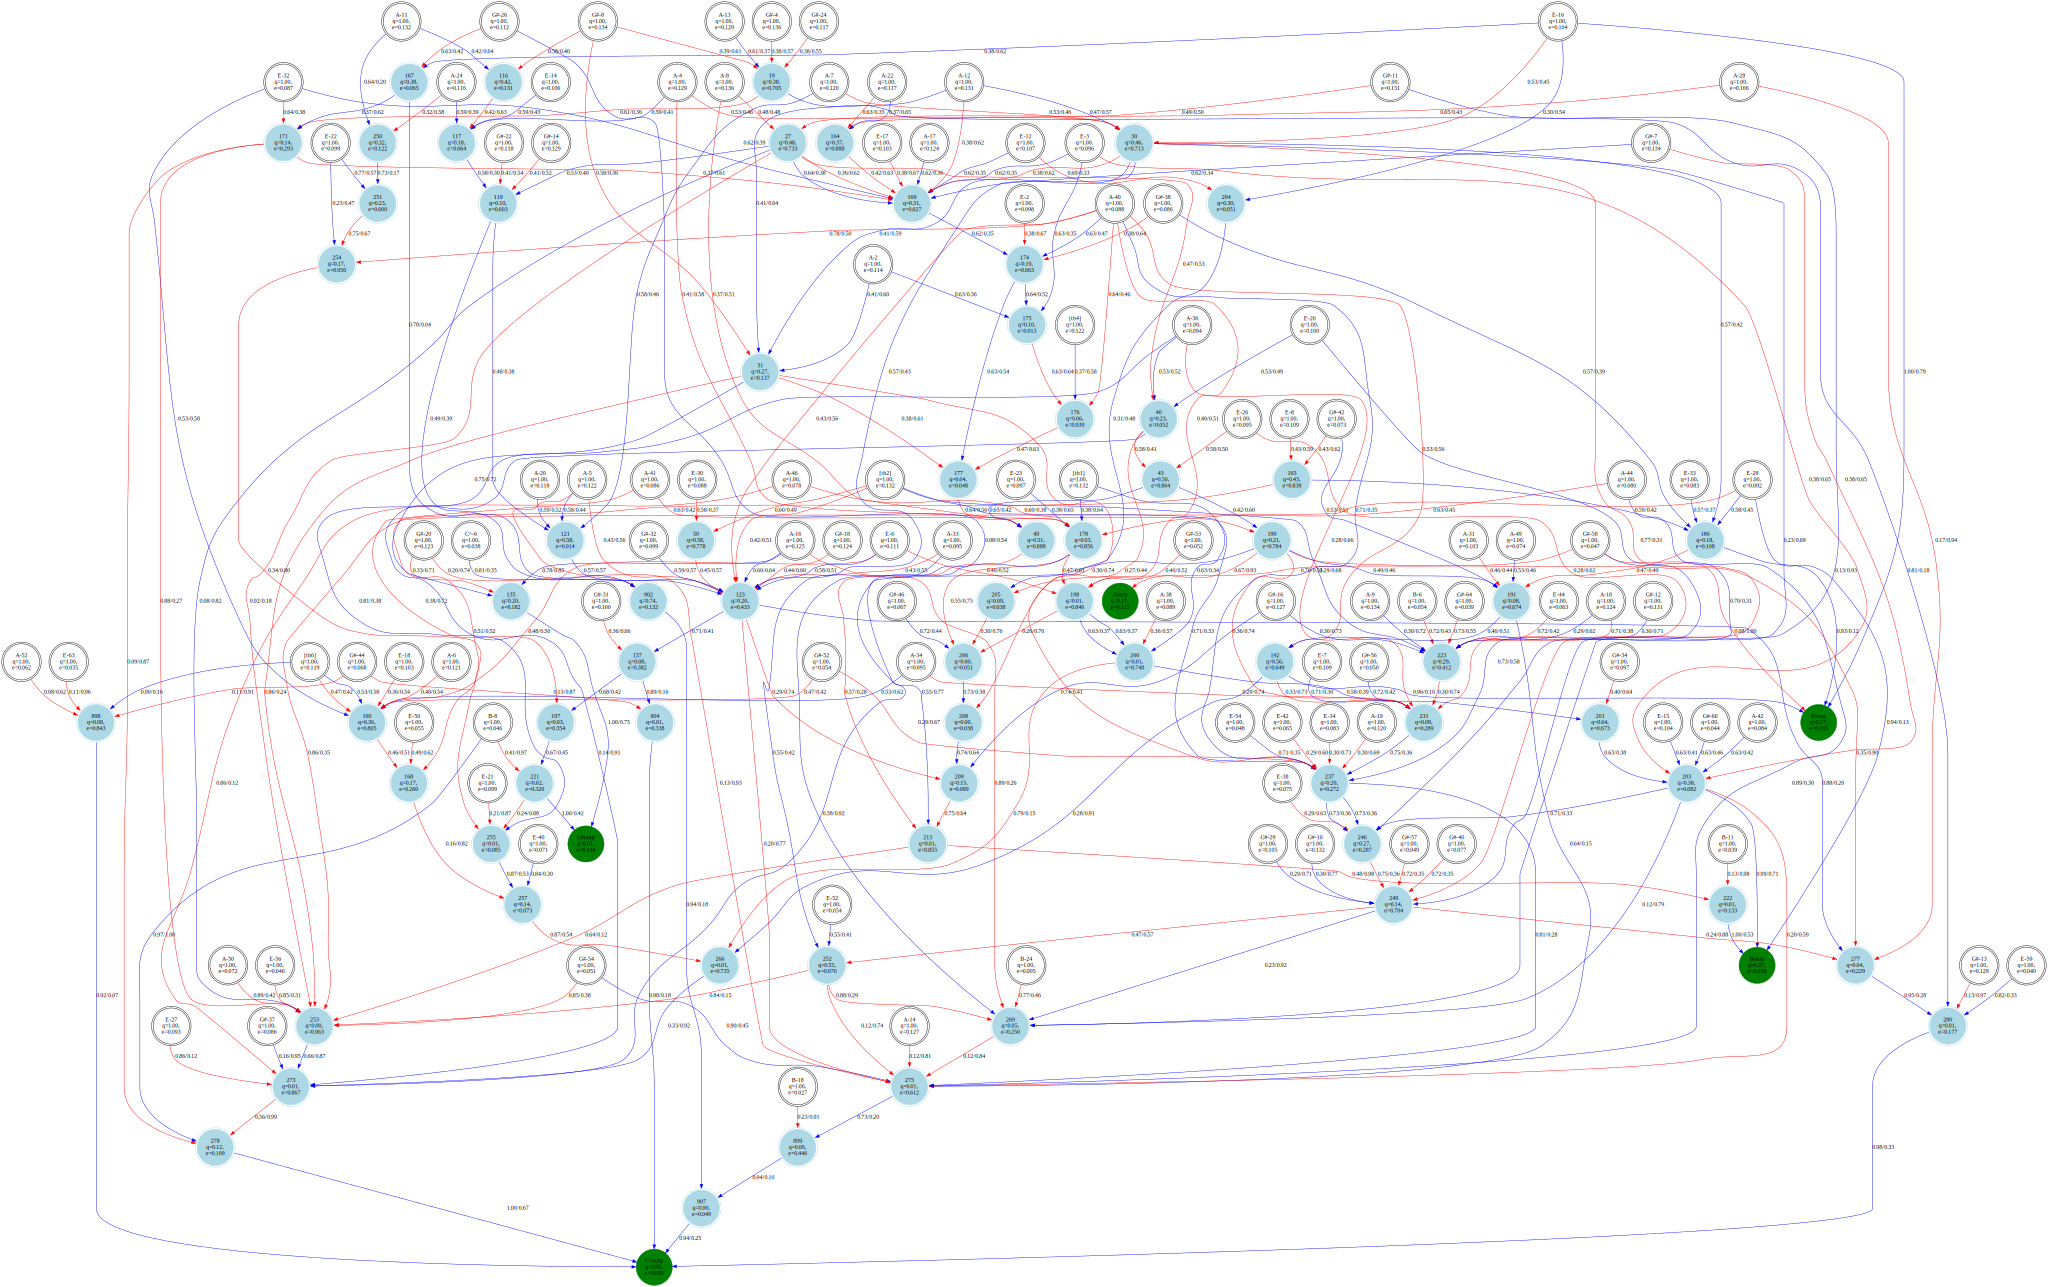

In [278]:
player.play_note.draw()

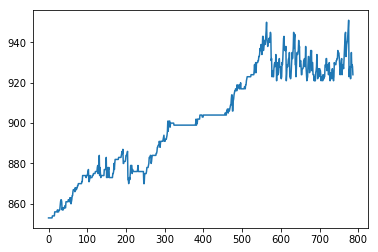

In [279]:
plt.plot(neurons)  # график количества нейронов в эпоху

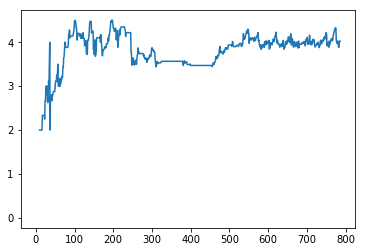

In [280]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

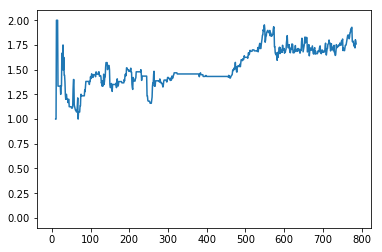

In [281]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

# Базовый вариант

In [282]:
player = Player()

In [283]:
errors = [kuznechik.notes.sum()]
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]
while errors[-1] > 0:
    errors.append(player.learn_to_play(kuznechik))
    neurons.append(len(player.play_note.neurons))
    stubs_outputs.append(stubs_output(player.play_note))
    stubs_inputs.append(stubs_input(player.play_note))
    print(errors[-1], end=" ")
    sys.stdout.flush()
    
    #if errors[-1] > errors[-2]:
    #    player.play_note.learning_rate += 1

75 82 86 78 98 93 69 73 69 69 72 77 64 77 75 80 73 62 69 90 79 75 73 65 62 74 76 71 70 74 72 75 77 99 107 93 

KeyboardInterrupt: 

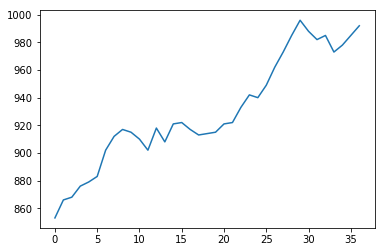

In [284]:
plt.plot(neurons)  # график количества нейронов в эпоху

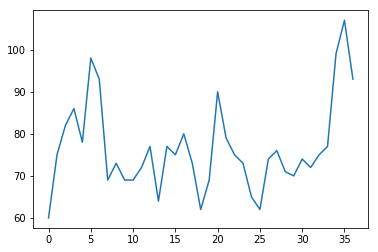

In [285]:
plt.plot(errors)  # график количества ошибок в эпоху

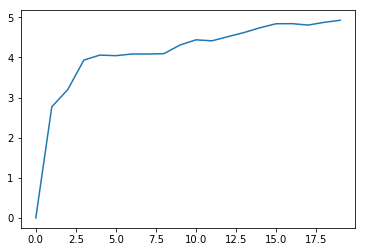

In [182]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

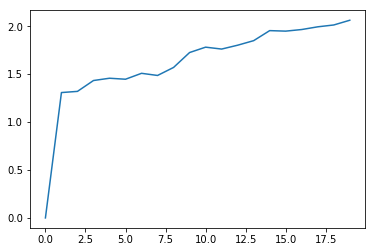

In [183]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

In [374]:
player.play_note.draw()

In [137]:
#player.play_note.draw().render('Бинарный слон') 

'Бинарный слон.png'

In [357]:
len(player.play_note.neurons)

947

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [138]:
player.improvise(kuznechik).play()

Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [139]:
simple_song = Song([12, -1, 11, -1, 9, -1, 8, -1])
result = player.improvise(simple_song)
result.play()

In [140]:
simple_song = Song('../basic midi/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [141]:
result.play()

## МНОГО ПЕСЕН

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [368]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [369]:
Songs = []
for i in range(1, 10):
    addAllTransposedVersions(Songs, Song('../basic midi/track (' + str(i) + ').mid'))

In [370]:
player = Player()

In [371]:
import random
random.shuffle(Songs)
prev_errors = np.array([1000 for i in range(len(Songs))])
neurons = []

In [372]:
while prev_errors.sum() > 10:
    errors = []
    for song in Songs:
        errors.append(player.learn_to_play(song))
        neurons.append(len(player.play_note.neurons))
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    
    prev_errors = np.array(errors)
    print("sum = ", prev_errors.sum())

99 111 91 75 73 79 101 121 59 107 74 71 146 99 174 98 70 76 69 101 97 80 111 
sum =  2182
128 116 57 115 82 76 90 89 73 58 71 53 67 66 85 168 82 63 53 70 77 56 67 
sum =  1862
78 66 42 55 52 64 69 79 36 58 58 47 54 44 73 57 56 60 45 62 60 37 64 
sum =  1316
71 56 37 39 54 53 62 73 35 61 61 54 82 50 78 59 71 72 50 89 68 46 87 
sum =  1408
62 73 49 58 60 68 65 100 55 79 67 41 69 52 69 62 67 70 52 77 67 55 82 
sum =  1499
78 58 40 53 50 54 67 74 39 67 94 66 63 58 72 84 74 67 72 99 84 52 80 
sum =  1545
87 60 48 48 65 75 88 88 55 67 92 78 71 72 87 95 89 77 47 103 74 57 73 
sum =  1696
95 58 51 44 64 69 82 67 44 62 81 67 55 56 75 73 58 52 52 61 62 66 75 
sum =  1469
75 68 35 54 56 55 70 77 40 55 73 102 70 50 72 62 73 70 45 64 53 43 73 
sum =  1435
75 59 50 50 55 54 59 69 40 48 58 64 59 51 67 59 59 57 58 75 98 59 73 
sum =  1396
92 63 71 66 61 69 73 69 63 52 63 68 49 53 59 67 57 51 49 68 63 50 66 
sum =  1442
69 69 36 44 56 48 63 71 43 46 58 50 46 42 63 48 53 64 49 61 63 40 68 
sum =  1250
7

KeyboardInterrupt: 

In [373]:
len(player.play_note.neurons)

1134

In [196]:
simple_song = Song('../basic midi/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

KeyboardInterrupt: 

In [143]:
result.save_file("181. Binary Elephant NN learned kuznechik (94 hidden neurons)")

In [144]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [145]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()